In [75]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pandas as pd
%matplotlib inline

# Hebbian Learning

In this notebook, we'll look at some examples and limitations of Hebbian learning via Oja's rule. Then we'll examine one extension of Hebbian learning called competitive learning ([Rumelhart and Zipser 1985](https://onlinelibrary.wiley.com/doi/abs/10.1207/s15516709cog0901_5)) where network units only change their weights when they have the largest activation to a stimulus.

We'll study simple networks with an input layer $x$ of length $m$, hidden layer $h$ of length $n$ and weight matrix $W$ of size $n \times m$ connecting the two. Throughout this notebook I try to use the convention that $i$ is an index into $x$ and $j$ is an index into $h$. The activation for the hidden unit $h_j$ is
$$
h_j = W_j x = \sum_{i=1}^m W_{ji} x_i
%h = Wx = \left[ \sum_{i=1}^m W_{ji} x_i \right]_{j=1}^n
$$

A standard rule for the change in weights in Hebbian learning is $\Delta W = h x'$ or $\Delta W_{ji} = h_j x_i$. However, since this results in unbounded growth of weights, we use Oja's rule which bounds the growth of weights to $\frac{1}{\alpha}$.

$$
\Delta W_{ji} = h_j x_i - \alpha h_j^2 W_{ji}
$$

As you might recall from your NEU502A homework earlier in the semester, this kind of linear Hebbian learning finds the first principal component of the dataset (for a wonderful & rigorous exposition, see Bruno Olshausen's notes [here](https://redwood.berkeley.edu/wp-content/uploads/2018/08/handout-hebb-PCA.pdf).

Here's the code we'll run through this notebook. We perform Hebbian learning some number of times, updating our weight matrix each time to the average $\Delta W$ over all the samples in our dataset.

In [86]:
def hebbian_learning(
    samples, num_output,
    *,
    num_epochs=100,
    competitive=False,
    seed=None,
    alpha=1,
):
    # Random seeds are good things!
    if seed:
        np.random.seed(seed)

    num_features, num_samples = samples.shape

    w = np.random.randn(num_features, num_output) * 1e-4

    for _ in range(num_epochs):
        dw = np.zeros((num_features, num_output))
        win_counts = np.zeros(num_output)

        for idx in range(num_samples):
            x = samples[:, idx]

            # Compute activation of hidden units
            h = x@w

            # Compute the change in w for this sample via Oja's rule
            dw_sample = h * x[:, None] - alpha * h ** 2 * w

            if competitive:
                # Only update for the winner
                updates = [np.argmax(h)]
            else:
                # Update for all nodes
                updates = range(num_output)

            # Add in this update
            for node in updates:
                dw[:, node] += dw_sample[:, node]
                win_counts[node] += 1

        # Take the average of the changes to w
        for node in range(num_output):
            # Make sure the node won at least once, otherwise this becomes NaN
            if win_counts[node] != 0:
                dw[:, node] /= win_counts[node]

        # Add the change to w
        w += dw

    return w

## A simple dataset

We'll first examine a simple and artificial dataset consisting of colored shapes. We assume two possible colors (orange or blue) and two possible shapes (hearts or diamonds) for a total fo four possible inputs: 🧡💙🔶🔷. We'll encode these inputs with one-hot encoding where every place in the input vector represents either a color or shape, coded with a 1 if that attribute is present in the input. If we let the places in the input vector represent `[orange, blue, heart, diamond]`, then a 💙 can be represented by `0 1 1 0`. Here are the codes for the other inputs:

|input|code|
|---|---|
|🧡|1 0 1 0|
|💙|0 1 1 0|
|🔶|1 0 0 1|
|🔷|0 1 0 1|

If you give a hebbian network only 🧡 and 🔷, what do you think it's hidden unit will become most responsive to? We'll explore this a little. We code the inputs as above.

In [87]:
data = np.array([
    [0.5, 0, 0.5, 0],
    [0, 0.5, 0, 0.5],
]).astype(np.float).T

weights = hebbian_learning(data, num_output=1, seed=40)

pd.DataFrame([
    (data[:, i], data[:, i] @ weights)
    for i in range(data.shape[1])
], columns=['Input', 'Activation'])

,Input,Activation
0,"[0.5, 0.0, 0.5, 0.0]",[-0.6006713857454204]
1,"[0.0, 0.5, 0.0, 0.5]",[0.3730869688781374]


The network nicely differentiates the above inputs with different levels of activity for each. We might wonder next what happens if we provide partial input. The training inputs above and these partial inputs all sum to 1 to make the final output comparable.

In [88]:
data = np.array([
    [1, 0, 0, 0], # Orange
    [0, 1, 0, 0], # Blue
    [0, 0, 1, 0], # Heart
    [0, 0, 0, 1], # Diamond
    [0, 0.5, 0.5, 0], # Blue Heart
    [1/3, 1/3, 1/3, 0], # Orange Blue Heart
    [1/4, 1/4, 1/4, 1/4], # Orange Blue Heart Diamond??
]).T

pd.DataFrame([
    (data[:, i], data[:, i] @ weights)
    for i in range(data.shape[1])
], columns=['Input', 'Activation'])

,Input,Activation
0,"[1.0, 0.0, 0.0, 0.0]",[-0.6006713857452561]
1,"[0.0, 1.0, 0.0, 0.0]",[0.3730869688758891]
2,"[0.0, 0.0, 1.0, 0.0]",[-0.6006713857455847]
3,"[0.0, 0.0, 0.0, 1.0]",[0.3730869688803857]
4,"[0.0, 0.5, 0.5, 0.0]",[-0.11379220843484777]
5,"[0.3333333333333333, 0.3333333333333333, 0.333...",[-0.2760852675383172]
6,"[0.25, 0.25, 0.25, 0.25]",[-0.11379220843364149]


The above suggests that the network is able to find the correlation in inputs we provide. It finds the first principal component of our dataset, with 🧡 on one end and 🔷 on the other. We can try to stump Hebbian learning by giving it all possible inputs:

In [89]:
data = np.array([
    [1/2, 0, 1/2, 0],
    [1/2, 0, 0, 1/2],
    [0, 1/2, 1/2, 0],
    [0, 1/2, 0, 1/2],
]).astype(np.float).T

weights = hebbian_learning(data, num_output=1, seed=42)

pd.DataFrame([
    (data[:, i], data[:, i] @ weights)
    for i in range(data.shape[1])
], columns=['Input', 'Activation'])

,Input,Activation
0,"[0.5, 0.0, 0.5, 0.0]",[0.49999976415276504]
1,"[0.5, 0.0, 0.0, 0.5]",[0.5000014819303862]
2,"[0.0, 0.5, 0.5, 0.0]",[0.4999985180653753]
3,"[0.0, 0.5, 0.0, 0.5]",[0.5000002358429965]


## Competitive Hebbian learning

To extend linear Hebbian learning beyond simply learning principal components, we add in competition among the hidden units, per [Rumelhart and Zipser 1985](https://onlinelibrary.wiley.com/doi/abs/10.1207/s15516709cog0901_5). The hidden unit with the greatest activation ($\arg \max_j h_j$) for a stimulus learns from it, while others do not. We formalize this in the following learning rule:

$$
\Delta W_{ji} = 
\begin{cases}
h_j x_i - \alpha h_j^2 W_{ji} & \text{if } j = \arg\max_{j'} h_{j'} \\
0 & \text{otherwise}
\end{cases}
$$

The above code already implements this under a flag. Calling `hebbian_learning(data, ..., competitive=True)` will run Hebbian learning via Oja's rule with winner-take-all learning as described above.


You can think of this learning as implementing a kind of clustering algorithm, tuning each hidden node to its most related inputs. Rumelhart and Zipser elaborate on this in Figure 3 of *Feature Discovery by Competitive Learning*. With a normalized dataset and normalized weights, each datapoint and node weight can be conceptualized as living on a sphere. The node with the most activity for a datapoint is the one closest to it. This figure schematizes this point, from *Introduction To The Theory Of Neural Computation* by Hertz, Krogh, Palmer.

<img src="resources/competitive.png" style="width: 600px;"/>

A more biologically plausible formulation of this learning rule might implement the dynamics of the winner-take-all process by having the activity of each hidden unit inhibit the others.

To look at the results of competitive learning, we'll use a small dataset from [Bruno Olshausen's competitive learning assignment](http://www.rctn.org/bruno/npb163/labs/wta-kohonen-hopnet.html). In the below plots, color denotes which hidden unit is most active for that input. We first use hebbian learning without competition, finding the units only extract the principal component:

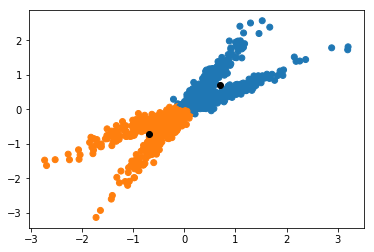

In [152]:
def plot_data_and_weights(w):
    cm = plt.get_cmap('tab10')
    group = np.argmax(w.T @ data, axis=0)
    plt.scatter(data[0], data[1], c=[cm.colors[g] for g in group])
    for pt in w.T:
        plt.plot(pt[0], pt[1], 'ko');

def norm(data):
    return data / np.linalg.norm(data, axis=0)[None, :]

w = hebbian_learning(norm(data), num_epochs=100, num_output=2, seed=60)
plot_data_and_weights(w)

Competitive learning with 2 units also only identifies the PC:

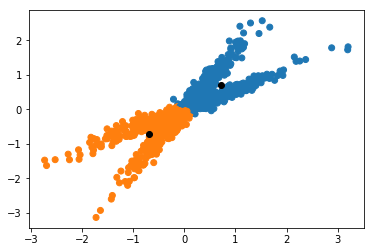

In [145]:
w = hebbian_learning(norm(data), num_epochs=100, num_output=2, seed=60, competitive=True)
plot_data_and_weights(w)

But competitive learning with 4 units can learn the dataset structure!

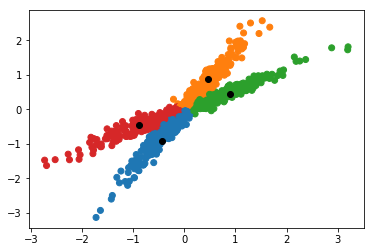

In [153]:
w = hebbian_learning(norm(data), num_epochs=100, num_output=4, seed=60, competitive=True)
plot_data_and_weights(w)

We'll close this section with an aside. This type of dataset (basically a combination of two linear datasets) is canonically shown to motivate the use of ICA (Independent Components Analysis), which we used for blink detection/removal in EEG analysis. Below we show the best 2 PCs from a PCA and the best 2 from an ICA. PCA ensures orthogonal components, but that hinders extracting the correlated but different clusters below.

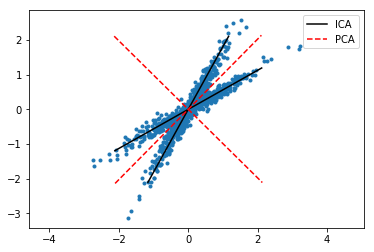

In [151]:
import sklearn.decomposition

f, ax = plt.subplots()

ica = sklearn.decomposition.FastICA(n_components=2, random_state=60)
ica.fit(data.T)
points = ica.components_

plt.plot(data[0], data[1], '.')
for pt in 30*points.T:
    plt.plot([-pt[0], pt[0]], [-pt[1], pt[1]], 'k-', label='ICA');

pca = sklearn.decomposition.PCA(n_components=2, random_state=60)
pca.fit(data.T)
points = pca.components_

for pt in 3*points.T:
    plt.plot([-pt[0], pt[0]], [-pt[1], pt[1]], 'r--', label='PCA');

by_label = dict(zip(*ax.get_legend_handles_labels()[::-1]))
plt.legend(by_label.values(), by_label.keys())
plt.axis('equal');

Questions:
- (From Bruno) Why are four neurons for competitive learning necessary to learn this dataset rather than just two? How would you change the competition and learning rule so that just two units are necessary?
- Hidden units only learn when they are most active for an input. Can you describe situations where hidden units might not learn and how you can prevent that?

## Demos

We'll now examine this competitive Hebbian network with a variety of datasets.

### Place cells

Following an example in Rumelhart and Zipser 1985, we'll see if our competitive Hebbian network can learn place cells. As input, we'll give the network a dataset of all adjacent places in a grid. Here's our grid with 2 adjacent cells in the lower left. We'll flatten the below matrix into a single vector as input to our network.

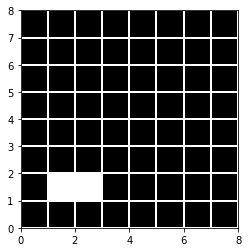

In [92]:
grid_size = (8, 8)

def plot_grid(grid, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    plt.sca(ax)
    plt.pcolormesh(grid, edgecolors='w', cmap='gray')
    ax.set_aspect('equal')

arr = np.zeros(grid_size)
arr[1, 1] = 1
arr[1, 2] = 1
plot_grid(arr)

We'll make a dataset of adjacent cells on the grid.

In [154]:
adjacent_cells = []
# For all x, y coordinates...
for x in range(grid_size[0]):
    for y in range(grid_size[1]):
        # For all changes in x and y (up, down, left, right)
        for dx, dy in [(0, -1), (0, +1), (-1, 0), (+1, 0)]:
            nx = x + dx
            ny = y + dy
            # Check to see if the resulting cell is in the grid
            if 0 <= nx < grid_size[0] and 0 <= ny < grid_size[1]:
                # If so, we can add this (x, y) and (nx, ny) as an input
                arr = np.zeros(grid_size)
                arr[x, y] = 1
                arr[nx, ny] = 1
                adjacent_cells.append(arr.flatten())

adjacent_cells = np.array(adjacent_cells).T
print(adjacent_cells.shape)

(64, 224)


We'll first look at what our non-competitive Hebbian learning looks like.

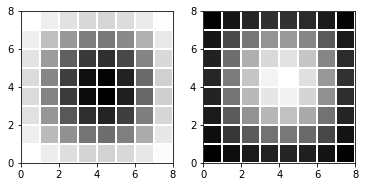

In [155]:
w = hebbian_learning(adjacent_cells, 2, num_epochs=1000, seed=42)

num_output = w.shape[1]
f, axes = plt.subplots(1, num_output, figsize=(6, 3))

for widx, ax in zip(range(num_output), axes.flat):
    plot_grid(w[:, widx].reshape(grid_size), ax=ax)

It finds what looks like a principal component, with the weight of one positive and the other negative. Now let's try competitive learning.

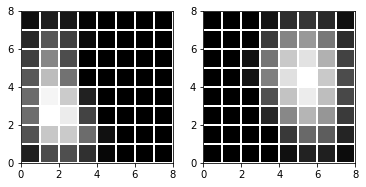

In [156]:
w = hebbian_learning(adjacent_cells, 2, competitive=True, num_epochs=1000, seed=42)

num_output = w.shape[1]
f, axes = plt.subplots(1, num_output, figsize=(6, 3))

for widx, ax in zip(range(num_output), axes.flat):
    plot_grid(w[:, widx].reshape(grid_size), ax=ax)

We find something that looks somewhat like 2 very broad place cells selecting for different regions of space! Increasing to 4 cells further subdivides space.

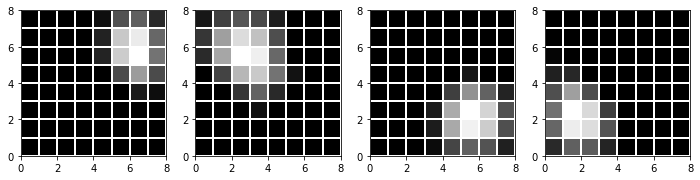

In [157]:
w = hebbian_learning(adjacent_cells, 4, competitive=True, num_epochs=1000, seed=42)

num_output = w.shape[1]
f, axes = plt.subplots(1, num_output, figsize=(12, 5))

for widx, ax in zip(range(num_output), axes.flat):
    plot_grid(w[:, widx].reshape(grid_size), ax=ax)

## Learning Jets & Sharks

We'll now attempt to learn the Jets & Sharks dataset with a 2-unit competitive Hebbian network. Data comes from the [PDP Handbook](https://web.stanford.edu/group/pdplab/pdphandbook/handbookch3.html). This dataset lists individuals, their gang membership (Jets or Sharks), age, schooling, marital status, and occupation. We'll hope our network can extract some of the regularities among these individuals.

We start by assembling our dataset:

In [158]:
data = [['Art', 'Jets', "40's", 'J.H.', 'Sing.', 'Pusher'],
 ['Al', 'Jets', "30's", 'J.H.', 'Mar.', 'Burglar'],
 ['Sam', 'Jets', "20's", 'COL.', 'Sing.', 'Bookie'],
 ['Clyde', 'Jets', "40's", 'J.H.', 'Sing.', 'Bookie'],
 ['Mike', 'Jets', "30's", 'J.H.', 'Sing.', 'Bookie'],
 ['Jim', 'Jets', "20's", 'J.H.', 'Div.', 'Burglar'],
 ['Greg', 'Jets', "20's", 'H.S.', 'Mar.', 'Pusher'],
 ['John', 'Jets', "20's", 'J.H.', 'Mar.', 'Burglar'],
 ['Doug', 'Jets', "30's", 'H.S.', 'Sing.', 'Bookie'],
 ['Lance', 'Jets', "20's", 'J.H.', 'Mar.', 'Burglar'],
 ['George', 'Jets', "20's", 'J.H.', 'Div.', 'Burglar'],
 ['Pete', 'Jets', "20's", 'H.S.', 'Sing.', 'Bookie'],
 ['Fred', 'Jets', "20's", 'H.S.', 'Sing.', 'Pusher'],
 ['Gene', 'Jets', "20's", 'COL.', 'Sing.', 'Pusher'],
 ['Ralph', 'Jets', "30's", 'J.H.', 'Sing.', 'Pusher'],

 ['Phil', 'Sharks', "30's", 'COL.', 'Mar.', 'Pusher'],
 ['Ike', 'Sharks', "30's", 'J.H.', 'Sing.', 'Bookie'],
 ['Nick', 'Sharks', "30's", 'H.S.', 'Sing.', 'Pusher'],
 ['Don', 'Sharks', "30's", 'COL.', 'Mar.', 'Burglar'],
 ['Ned', 'Sharks', "30's", 'COL.', 'Mar.', 'Bookie'],
 ['Karl', 'Sharks', "40's", 'H.S.', 'Mar.', 'Bookie'],
 ['Ken', 'Sharks', "20's", 'H.S.', 'Sing.', 'Burglar'],
 ['Earl', 'Sharks', "40's", 'H.S.', 'Mar.', 'Burglar'],
 ['Rick', 'Sharks', "30's", 'H.S.', 'Div.', 'Burglar'],
 ['Ol', 'Sharks', "30's", 'COL.', 'Mar.', 'Pusher'],
 ['Neal', 'Sharks', "30's", 'H.S.', 'Sing.', 'Bookie'],
 ['Dave', 'Sharks', "30's", 'H.S.', 'Div.', 'Pusher']]

print('number of members', len(data))

# We are going to drop the name from the dataset...
for idx in range(len(data)):
    data[idx] = data[idx][1:]

# Gathering names of features and list of all feature values for one-hot encoding later...
feature_values = []
allfeatures = []
for featureidx in range(len(data[0])):
    values = sorted(list(set([row[featureidx] for row in data])))
    feature_values.append(values)
    allfeatures += values
feature_values

number of members 27


[['Jets', 'Sharks'],
 ["20's", "30's", "40's"],
 ['COL.', 'H.S.', 'J.H.'],
 ['Div.', 'Mar.', 'Sing.'],
 ['Bookie', 'Burglar', 'Pusher']]

We make a one-hot coding of the dataset:

In [162]:
def onehot(index, total):
    arr = np.zeros(total)
    arr[index] = 1
    return arr
assert (onehot(1, 3) == np.array([0, 1, 0])).all()

def row_to_onehot(row):
    x = []
    for featureidx in range(len(row)):
        # This handles partial queries...
        if row[featureidx] is None:
            x.append(np.zeros(len(feature_values[featureidx])))
            continue
        # This encodes values
        idx = feature_values[featureidx].index(row[featureidx])
        x.append(onehot(idx, len(feature_values[featureidx])))
    return np.hstack(x)

print(row_to_onehot(data[0]))
print(row_to_onehot(['Jets', None, None, None, None]))

X = np.array([row_to_onehot(row) for row in data]).T

[1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Now we do hebbian learning! Our two units extract some of the regularity in the datset: Jets are often in their 20s, Sharks in their 30s.

Text(0.5, 1.0, 'Competitive Hebbian Learning weights')

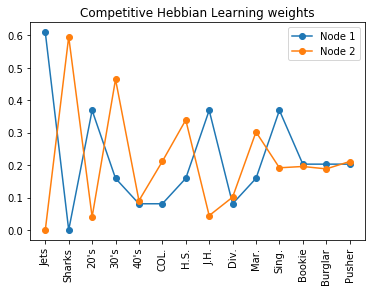

In [165]:
w_jets_sharks = hebbian_learning(norm(X), num_output=2, competitive=True, seed=42)

f, ax = plt.subplots()
ls = plt.plot(w_jets_sharks, '-o')
plt.legend(ls, ['Node 1', 'Node 2'])
plt.xticks(range(len(allfeatures)), rotation=90, labels=allfeatures);
plt.title('Competitive Hebbian Learning weights')

Weights of units can be relatively well-explained by the correlations for each of the gangs.

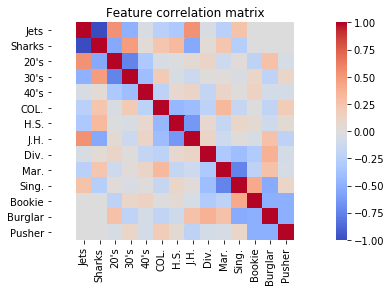

In [166]:
import seaborn as sns
sns.heatmap(
    np.corrcoef(X),
    cmap='coolwarm', vmin=-1, vmax=+1,
    xticklabels=allfeatures,
    yticklabels=allfeatures,
)
plt.axis('equal')
plt.title('Feature correlation matrix');

We'll close with an attempt at pattern completion. Given a trained network and a query like "30's", we might expect the network to activate related nodes, like Sharks. To approximate the type of network used for this, we activate the network with a query $x$, then project that activity back through the weights to get $\hat{x}$, a pattern-completed version of the query.
$$
\hat{x} = W^{-1} h = W^{-1} W x
$$

This example shows that the pattern completion is sensitive to input statistics: 30's implies you're likely to be in the Sharks, unless you went to J.H., then you're likely in the Jets.

['Jets', "30's", 'J.H.', 'Mar.', 'Burglar']
['Jets', "30's", 'J.H.', 'Sing.', 'Bookie']
['Jets', "30's", 'H.S.', 'Sing.', 'Bookie']
['Jets', "30's", 'J.H.', 'Sing.', 'Pusher']
['Sharks', "30's", 'COL.', 'Mar.', 'Pusher']
['Sharks', "30's", 'J.H.', 'Sing.', 'Bookie']
['Sharks', "30's", 'H.S.', 'Sing.', 'Pusher']
['Sharks', "30's", 'COL.', 'Mar.', 'Burglar']
['Sharks', "30's", 'COL.', 'Mar.', 'Bookie']
['Sharks', "30's", 'H.S.', 'Div.', 'Burglar']
['Sharks', "30's", 'COL.', 'Mar.', 'Pusher']
['Sharks', "30's", 'H.S.', 'Sing.', 'Bookie']
['Sharks', "30's", 'H.S.', 'Div.', 'Pusher']


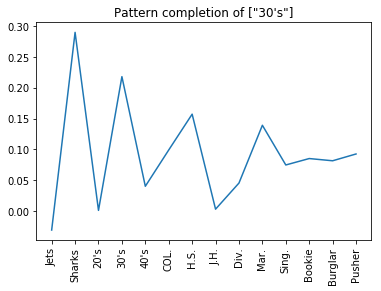

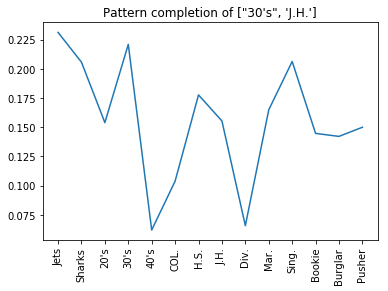

In [184]:
def pattern_complete(query):
    # we compute unit activations
    h = query @ w_jets_sharks

    # and then project back into feature space
    #pattern_completion = w_jets_sharks @ h
    pattern_completion = h @ np.linalg.pinv(w_jets_sharks)

    active = [name for name, bit in zip(allfeatures, query) if bit]
    plt.figure()
    plt.title(f'Pattern completion of {active}')
    plt.plot(pattern_completion)
    plt.xticks(range(len(allfeatures)), rotation=90, labels=allfeatures);

for row in data:
    if row[1] == "30's":
        print(row)
pattern_complete(row_to_onehot([None, "30's", None, None, None]))
pattern_complete(row_to_onehot([None, "30's", "J.H.", None, None]))